In [1]:
import os
import re

from dotenv import find_dotenv, load_dotenv
from IPython.display import display
from rich import print as rprint
from rich.markdown import Markdown
from rich.pretty import Pretty
from rich.text import Text

In [2]:
load_dotenv(find_dotenv('.env'))

True

In [3]:
os.environ["LANGCHAIN_PROJECT"] = "RAG From Scratch: Part 10-1 (Routing - Logical Routing)"

# Routing

![](images/routing-01.png)

# Part 10-1: Logical Routing

![](images/10-01-logical-routing.png)

## Configure components

In [4]:
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

In [5]:
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=1
)
llm.invoke("Hello")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 8, 'total_tokens': 18, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b376dfbbd5', 'id': 'chatcmpl-BKOjlWOATT3EqOPeiKgf74NbXjSBo', 'finish_reason': 'stop', 'logprobs': None}, id='run-206f4bf3-f315-48ef-b320-7332eb5097cc-0', usage_metadata={'input_tokens': 8, 'output_tokens': 10, 'total_tokens': 18, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [6]:
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
len(embeddings.embed_query("Hello"))

1536

## RAG

In [7]:
from typing import Literal, TypedDict

from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import END, START, StateGraph
from pydantic import BaseModel, Field

In [8]:
system_prompt = """You are an expert at routing a user question to the appropriate data source.

Based on the programming language the question is referring to, route it to the relevant data source."""
print(system_prompt)

You are an expert at routing a user question to the appropriate data source.

Based on the programming language the question is referring to, route it to the relevant data source.


In [9]:
class RouteInfo(BaseModel):
    """Route a user query to the most relevant data source."""

    data_source: Literal["python_docs", "js_docs", "golang_docs"] = Field(
        ...,
        description="Given a user question choose which data source would be most relevant for answering their question",
    )

structured_llm = llm.with_structured_output(RouteInfo, method="function_calling")

In [10]:
python_query = """Why doesn't the following code work:

from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_messages(["human", "speak in {language}"])
prompt.invoke("french")
"""
javascript_query = """Which arguments has getElementById function?"""
golang_query = """What is struct?"""

In [11]:
class State(TypedDict):
    question: str
    data_source: str
    context: str
    answer: str

In [12]:
def select_data_source(state: State):
    response = structured_llm.invoke([
        SystemMessage(content=system_prompt),
        HumanMessage(content=state["question"])
    ])
    return {"data_source": response.data_source}


def route_query(state: State) -> Literal["python_docs", "js_docs", "golang_docs"]:
    return state['data_source']


def retrieve_python_docs(state: State):
    return {'context': 'Python documentation'}


def retrieve_js_docs(state: State):
    return {'context': 'Javascript documentation'}


def retrieve_golang_docs(state: State):
    return {'context': 'Go documentation'}


def generate_answer(state: State):
    return {'answer': f'Answer based on {state["context"]}'}

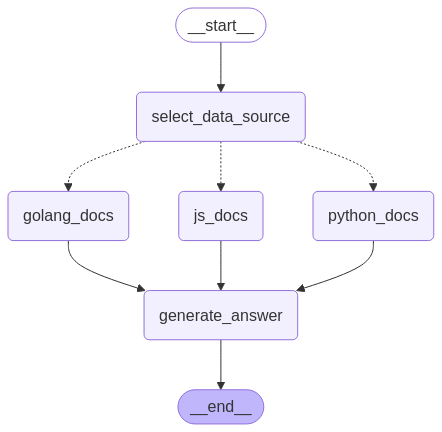

In [13]:
graph_builder = StateGraph(State)

graph_builder.add_node("select_data_source", select_data_source)
graph_builder.add_node("python_docs", retrieve_python_docs)
graph_builder.add_node("js_docs", retrieve_js_docs)
graph_builder.add_node("golang_docs", retrieve_golang_docs)
graph_builder.add_node("generate_answer", generate_answer)

graph_builder.add_edge(START, "select_data_source")
graph_builder.add_conditional_edges(
    "select_data_source", 
    route_query, 
    ["python_docs", "js_docs", "golang_docs"]
)
graph_builder.add_edge("python_docs", "generate_answer")
graph_builder.add_edge("js_docs", "generate_answer")
graph_builder.add_edge("golang_docs", "generate_answer")
graph_builder.add_edge("generate_answer", END)

graph = graph_builder.compile()
graph

In [14]:
print(python_query)
response = graph.invoke({"question": python_query})
rprint(response)

Why doesn't the following code work:

from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_messages(["human", "speak in {language}"])
prompt.invoke("french")



{
    'question': 'Why doesn\'t the following code work:\n\nfrom langchain_core.prompts import 
ChatPromptTemplate\n\nprompt = ChatPromptTemplate.from_messages(["human", "speak in 
{language}"])\nprompt.invoke("french")\n',
    'data_source': 'python_docs',
    'context': 'Python documentation',
    'answer': 'Answer based on Python documentation'
}

In [15]:
print(javascript_query)
response = graph.invoke({"question": javascript_query})
rprint(response)

Which arguments has getElementById function?


{
    'question': 'Which arguments has getElementById function?',
    'data_source': 'js_docs',
    'context': 'Javascript documentation',
    'answer': 'Answer based on Javascript documentation'
}

In [16]:
print(golang_query)
response = graph.invoke({"question": golang_query})
rprint(response)

What is struct?


{
    'question': 'What is struct?',
    'data_source': 'golang_docs',
    'context': 'Go documentation',
    'answer': 'Answer based on Go documentation'
}